### Imports 

In [1]:
import pandas as pd
from glob import glob
import shutil
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
import random
import os
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import applications
import re

### Load train data and visualize 

In [2]:
df1 = pd.read_csv('../dataset/v0_BarPlot_splitted.csv').drop(columns=['Unnamed: 0'])
df2 = pd.read_csv('../dataset/v0_LinePlot_splitted.csv').drop(columns=['Unnamed: 0'])
df3 = pd.read_csv('../dataset/v0_Scatter_splitted.csv').drop(columns=['Unnamed: 0'])
df = pd.concat([df1,df2,df3]).reset_index().drop(columns=['index'])
df.head(10)

,model,type,general_figure_info,image_index,data_split,graph_dir
0,{'name': 'Percentage of part-time workers in L...,bar_plot,{'title': {'text': 'Percentage of part-time wo...,0,train,../dataset/train/barplot\Bar0.png
1,"{'name': 'Total debt of Jamaica', 'color': 'k'...",bar_plot,"{'title': {'text': 'Total debt of Jamaica', 'b...",1,train,../dataset/train/barplot\Bar1.png
2,{'name': 'Arable land in different countries a...,bar_plot,{'title': {'text': 'Arable land in different c...,2,train,../dataset/train/barplot\Bar2.png
3,{'name': 'Percentage of households with a fema...,bar_plot,{'title': {'text': 'Percentage of households w...,3,train,../dataset/train/barplot\Bar3.png
4,{'name': 'Percentage of people living with HIV...,bar_plot,{'title': {'text': 'Percentage of people livin...,4,train,../dataset/train/barplot\Bar4.png
5,{'name': 'Customs and other import duties (as ...,bar_plot,{'title': {'text': 'Customs and other import d...,5,train,../dataset/train/barplot\Bar5.png
6,{'name': 'Percentage of full-time male workers...,bar_plot,{'title': {'text': 'Percentage of full-time ma...,6,validation,../dataset/validation/barplot\Bar6.png
7,"{'name': 'Waste generated by Central Europe', ...",bar_plot,{'title': {'text': 'Waste generated by Central...,7,train,../dataset/train/barplot\Bar7.png
8,{'name': 'Percentage of part-time workers in t...,bar_plot,{'title': {'text': 'Percentage of part-time wo...,8,train,../dataset/train/barplot\Bar8.png
9,{'name': 'Calories needed to lift the undernou...,bar_plot,{'title': {'text': 'Calories needed to lift th...,9,train,../dataset/train/barplot\Bar9.png


In [3]:
#Select a random train plot
random_index = random.randint(0,len(df)-1)
selected_chart = df.iloc[random_index]['graph_dir']
index_plot = re.findall(r'[0-9]+',selected_chart.split('\\')[-1].split('.')[0] )
plot_type = re.findall(r'[A-Za-z]+', selected_chart.split('\\')[-1].split('.')[0] )

if plot_type[0] == 'Bar':
    clean_plot_type = 'bar_plot'
elif plot_type[0] == 'Line':
    clean_plot_type = 'line_plot'
else: 
    clean_plot_type = 'Scatter_plot'

In [4]:
idx = df[(df['image_index']==int(index_plot[0]))& (df['type']==clean_plot_type)].index[0]
d1 = eval(df.iloc[idx]['model'])
d2 = eval(df.iloc[idx]['general_figure_info'])

In [5]:
#d1 = eval(df.iloc[index_plot]['model'][int(index_plot[0])])
#d2 = eval(df.iloc[index_plot]['general_figure_info'][int(index_plot[0])])
#key_list = ['bbox','bboxes','bar_bboxes']

### Data visualization

In [6]:
bbox_and_bboxes_data = []
if 'bar_bboxes' in (list(d1.keys())): 
    bbox_and_bboxes_data.append({'Bar_bboxes':d1['bar_bboxes']})
    
bbox_and_bboxes_data.append({'title_bbox': d2['title']['bbox']})
bbox_and_bboxes_data.append({'x_axis_label_bbox':d2['x_axis']['label']['bbox']})
bbox_and_bboxes_data.append({'x_axis_tick_labels_bboxes':d2['x_axis']['tick_labels']['bboxes']})
bbox_and_bboxes_data.append({'y_axis_label_bbox':d2['y_axis']['label']['bbox']})
bbox_and_bboxes_data.append({'y_axis_tick_labels_bboxes': d2['y_axis']['tick_labels']['bboxes']})

In [7]:
chart_array = cv2.imread(selected_chart)
y_factor, x_factor = [x/640 for x in chart_array.shape[0:2]]
chart_array = cv2.resize(chart_array, (640,640))
for element in bbox_and_bboxes_data: 
    for k,v in element.items(): 
        if isinstance(element[k],dict):
            image = chart_array
            start_point = (round(element[k]['x']/x_factor), round(chart_array.shape[0]-element[k]['y']/y_factor))
            end_point = (round(element[k]['x']/x_factor + element[k]['w']/x_factor), round((chart_array.shape[0]-element[k]['y']/y_factor)-(element[k]['h']/y_factor)))
            color = (255,0,0)
            thickness = 3
            chart_array = cv2.rectangle(image , start_point, end_point, color, thickness)
        elif isinstance(element[k], list):
            for sub_element in element[k]: 
                image = chart_array
                start_point = (round(sub_element['x']/x_factor), round(chart_array.shape[0]-sub_element['y']/y_factor))
                end_point = (round(sub_element['x']/x_factor + sub_element['w']/x_factor), round((chart_array.shape[0]-sub_element['y']/y_factor)-(sub_element['h']/y_factor)))
                color = (255,0,0)
                thickness = 3
                chart_array = cv2.rectangle(image , start_point, end_point, color, thickness)

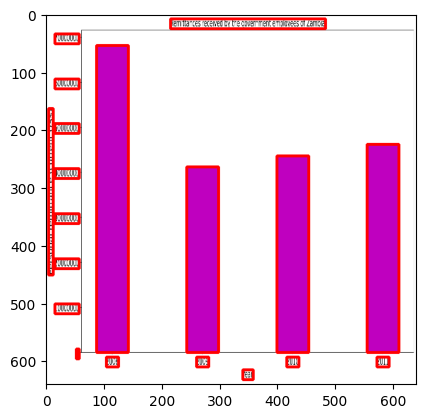

In [8]:
plt.imshow(chart_array)

### Data preprocessing - Prepare data for training
We also convert everything to the format that the training loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).



In [9]:
df['bboxes_resized'] = np.nan
for i in range(0,len(df)): 
    selected_chart = df.iloc[i]['graph_dir']
    index_plot = re.findall(r'[0-9]+',selected_chart.split('\\')[-1].split('.')[0] )
    plot_type = re.findall(r'[A-Za-z]+', selected_chart.split('\\')[-1].split('.')[0] )
    
    d1 = eval(df.iloc[index_plot]['model'][int(index_plot[0])])
    d2 = eval(df.iloc[index_plot]['general_figure_info'][int(index_plot[0])])
    
    bbox_and_bboxes_data = []
    if 'bar_bboxes' in (list(d1.keys())): 
        bbox_and_bboxes_data.append({'Bar_bboxes':d1['bar_bboxes']})

    bbox_and_bboxes_data.append({'title_bbox': d2['title']['bbox']})
    bbox_and_bboxes_data.append({'x_axis_label_bbox':d2['x_axis']['label']['bbox']})
    bbox_and_bboxes_data.append({'x_axis_tick_labels_bboxes':d2['x_axis']['tick_labels']['bboxes']})
    bbox_and_bboxes_data.append({'y_axis_label_bbox':d2['y_axis']['label']['bbox']})
    bbox_and_bboxes_data.append({'y_axis_tick_labels_bboxes': d2['y_axis']['tick_labels']['bboxes']})
    
    chart_array = cv2.imread(selected_chart)
    y_factor, x_factor = [x/640 for x in chart_array.shape[0:2]]
    chart_array = cv2.resize(chart_array, (640,640))
    for element in bbox_and_bboxes_data: 
        for k,v in element.items(): 
            if isinstance(element[k],dict):
                element[k]['x'] = element[k]['x']/x_factor
                element[k]['y']= element[k]['y']/y_factor
                element[k]['w']= element[k]['w']/x_factor
                element[k]['h']= element[k]['h']/y_factor

            elif isinstance(element[k], list):
                for sub_element in element[k]: 
                    sub_element['x'] = sub_element['x']/x_factor
                    sub_element['y'] = sub_element['y']/y_factor
                    sub_element['w'] = sub_element['w']/x_factor
                    sub_element['h'] = sub_element['h']/y_factor
    df['bboxes_resized'][i] = bbox_and_bboxes_data
    #df.loc[i,'bboxes_normalized'] = bbox_and_bboxes_data

C:\Users\rlope\anaconda3\envs\cbank_env\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\rlope\anaconda3\envs\cbank_env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [22]:
num_classes = 6
category_index = {
    'bar_bboxes_id': {'id': 1, 'name': 'bar_bbox'},
    'title_bbox_id': {'id': 2, 'name': 'title_bbox'}, 
    'x_axis_label_bbox_id': {'id': 3, 'name': 'x_axis_label_bbox'}, 
    'x_axis_tick_label_bbox_id': {'id': 4, 'name': 'x_axis_tick_label_bbox'}, 
    'y_axis_label_bbox_id': {'id': 5, 'name': 'y_axis_label_bbox'}, 
    'y_axis_tick_label_bbox_id': {'id': 6, 'name': 'y_axis_tick_label_bbox'}
                }

Convert class labels to one-hot; convert everything to tensors.
The `label_id_offset` here shifts all classes by a certain number of indices;we do this here so that the model receives one-hot labels where non-background classes start counting at the zeroth index.  This is ordinarily just handled automatically in our training binaries, but we need to reproduce it here.


In [ ]:
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


In [32]:
#Read train images and resize them to (664,664)
train_image_np = []
for plot_dir in df[df['data_split'] == 'train']['graph_dir']: 
    train_image_np.append(cv2.resize(cv2.imread(plot_dir),(664,664)))

Tengo los paths de las imagenes, tengo los bboxes preprocesados a 664,664 shape. Toca definir entreno

In [ ]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.

duck_class_id = 1
num_classes = 1

category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

In [28]:
df.iloc[0]['general_figure_info'] #title, x_axis_bboxes, y_axis_bboxes, ticks_bboxes, 

{'title': {'text': 'Percentage of part-time workers in Luxembourg',
  'bbox': {'x': 1154.9027777777778,
   'y': 1517.9999999999995,
   'w': 995.75,
   'h': 42.0}},
 'x_axis': {'tick_labels': {'value': ['1991', '1992', '1993', '1994', '1995'],
   'bboxes': [{'x': 339.94689713224193,
     'y': 73.11111111111116,
     'w': 105.75,
     'h': 42.0},
    {'x': 969.9873374550098, 'y': 73.11111111111116, 'w': 105.625, 'h': 42.0},
    {'x': 1599.8402777777776, 'y': 73.11111111111116, 'w': 105.875, 'h': 42.0},
    {'x': 2229.8807181005454, 'y': 73.11111111111116, 'w': 105.75, 'h': 42.0},
    {'x': 2859.8586584233135,
     'y': 73.11111111111116,
     'w': 105.75,
     'h': 42.0}]},
  'ticks_coordinates': {'value': [0, 1, 2, 3, 4],
   'bboxes': [{'x': 392.82189713224193, 'y': 134.5555555555556},
    {'x': 1022.7998374550098, 'y': 134.5555555555556},
    {'x': 1652.7777777777776, 'y': 134.5555555555556},
    {'x': 2282.7557181005454, 'y': 134.5555555555556},
    {'x': 2912.7336584233135, 'y': 134.